# ガウス過程の実装

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import time
from mpl_toolkits.mplot3d import Axes3D 

import numpy as np
from scipy import stats
import scipy as sp
from PIL import Image, ImageDraw

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
class LinearRegression:
    '''平均と精度が未知の多次元ガウス分布の学習
    '''
    def __init__(self, lam, w_m, w_lam):
        '''事前分布の初期パラメータを設定する
        inputs : lam, float, lam > 0
                      w_m, array(D * 1)
                      w_lam, array(D * D), lam_w > 0
        '''
        self.lam = lam
        self.w_m = np.array(w_m)
        self.w_lam = np.array(w_lam)
        self.w_lam_inv = np.linalg.inv(self.w_lam)
        
        self.D = w_lam.shape[0]
        
    def fit(self, X, Y):
        '''試行X後の事後分布によって事前分布を更新
        inputs : X, array(D * N)
                      Y, array(1 * N)
        return : None
        '''
        tmp = np.zeros((self.D, self.D))
        for i in range(X.shape[1]):
            tmp += np.dot(X[:, i].reshape(self.D, 1), X[:, i].reshape(1, self.D))
        w_lam_old = np.array(self.w_lam)
        self.w_lam += self.lam*tmp
        self.w_lam_inv = np.linalg.inv(self.w_lam)
        tmp = self.lam * np.dot(X, Y.reshape(-1, 1)) + np.dot(w_lam_old, self.w_m.reshape(-1, 1))
        self.w_m = np.dot(self.w_lam_inv, tmp)
        return 
                
    def pred(self, X):
        '''学習したパラメータをつかって新たなデータで回帰
        inputs : X, array(D * N)
        return : array(N * D)
        '''
        return np.dot(self.w_m.reshape(1, -1), X)

    def pred_1sigma(self, X):
        '''学習したパラメータをつかって新たなデータで回帰
        inputs : X, array(D * N)
        return : array(N * D)
        '''
        sigmas = []
        for i in range(X.shape[1]):
            sigmas.append((1/self.lam) + np.dot(np.dot(X[:,i].T, self.w_lam_inv), X[:,i]))
        return np.array(sigmas)

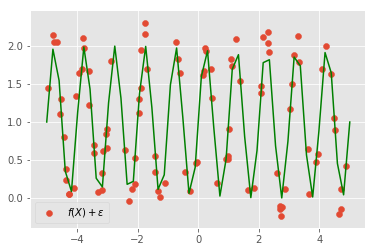

In [3]:
# ターゲットの分布
sigma_y = 0.2

N = 100
np.random.seed(42)
train_X = np.random.uniform(-5, 5, N)
train_y = np.sin(2 * np.pi * train_X) + np.random.normal(0, sigma_y, N) + 1
plt.plot(np.linspace(-5,5), np.sin(2 * np.pi * np.linspace(-5, 5)) + 1, "g")
# plt.scatter(train_X, np.sin(2 * np.pi * train_X)+1, c="b", label=r"$f(X)$")
plt.scatter(train_X, train_y, label=r"$f(X) + \epsilon$")
plt.legend()
plt.show()

## ベイズ線形回帰
事前分布にガウス分布を仮定したガウス線形回帰

before learning


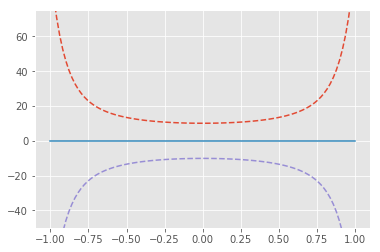

after 10 samples
0.00018453598022460938


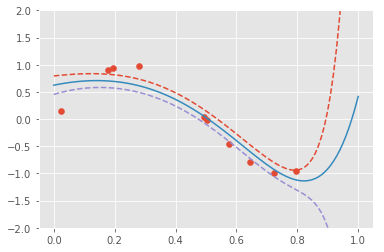

after 20 samples
0.00019240379333496094


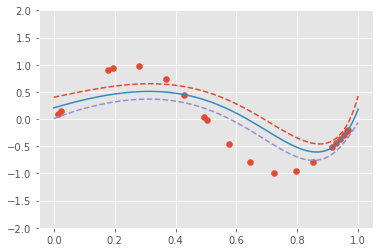

after 30 samples
0.00018858909606933594


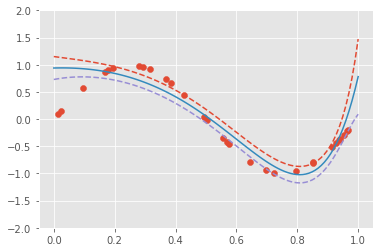

after 40 samples
0.00018978118896484375


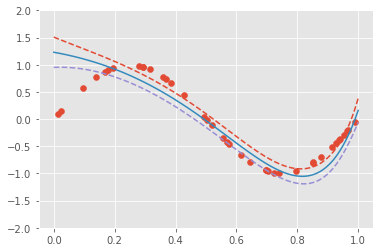

after 50 samples
0.00019168853759765625


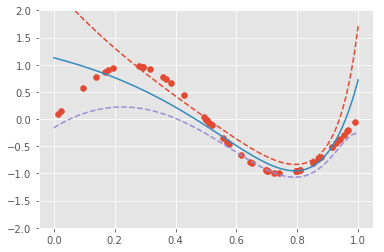

after 60 samples
0.00017905235290527344


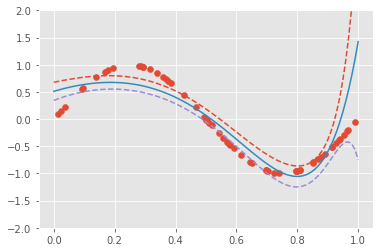

after 70 samples
0.00017642974853515625


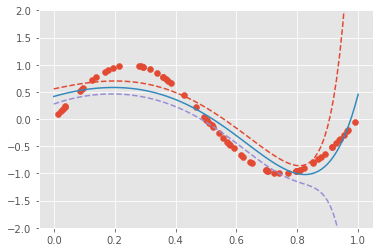

after 80 samples
0.00017714500427246094


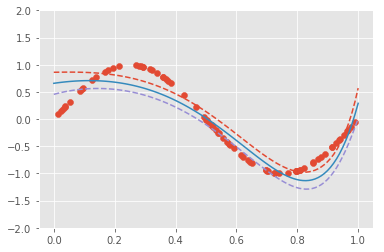

after 90 samples
0.000186920166015625


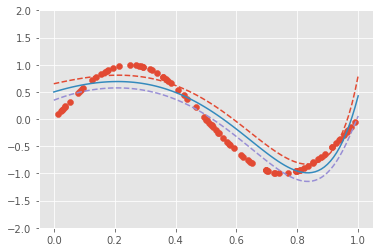

after 100 samples
0.0030934810638427734


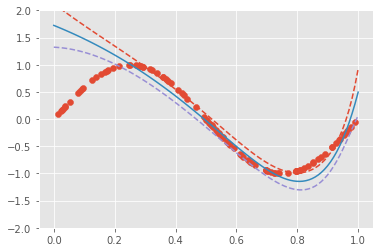

In [4]:
# 初期設定
dim = 10
lam = 10
w_m = np.zeros(dim)
w_sigma = np.eye(dim) * 10
w_lam = np.linalg.inv(w_sigma)

lr = LinearRegression(lam, w_m, w_lam)

# # 学習前
print("before learning")

# 予測分布
X = np.linspace(-1, 1,100) 
data = np.array([X**i for i in range(dim)])
pred = lr.pred(data).reshape(-1)
one_sigma =  lr.pred_1sigma(data).reshape(-1)
plt.plot(X, pred+one_sigma, linestyle="dashed")
plt.plot(X, pred)
plt.plot(X, pred-one_sigma, linestyle="dashed")
plt.ylim(-50, 75)
plt.show()
# show_img(X, sampled, "before learning", IMG_PATH+f"{img_num}.png")


N = 10
max_iter = 10
X_all = np.zeros(2)
Y_all = np.zeros(2)
for i in range(max_iter):
    lr = LinearRegression(lam, w_m, w_lam)
    print(f"after {N*(i+1)} samples")
    # 真のモデルからのデータ
    X = np.random.uniform(0, 1, size=N)
    data = np.array([X**i for i in range(dim)])
    Y = np.sin(2 * np.pi * X)
#     Y =  X**2 + 10*np.sin(X)
    X_all = np.r_[X_all, X]; Y_all = np.r_[Y_all, Y]
    
    # 事後分布の更新
    start = time.time()
    lr.fit(data, Y)
    print(time.time() - start)
#     print(gauss.show_params())
    
    # 予測分布
    X = np.linspace(0,1,100) 
    data = np.array([X**i for i in range(dim)])
    pred = lr.pred(data).reshape(-1)
    one_sigma =  lr.pred_1sigma(data).reshape(-1)
    plt.scatter(X_all[2:], Y_all[2:])
    plt.plot(X, pred+one_sigma, linestyle="dashed")
    plt.plot(X, pred)
    plt.plot(X, pred-one_sigma, linestyle="dashed")
    plt.ylim(-2, 2)
    plt.show()
# ims = []
# for i in range(max_iter+1):
#     ims.append(Image.open(IMG_PATH+f"{i}.png"))
# ims[0].save(IMG_PATH+"out.gif", save_all=True, append_images=ims[1:], duration=60)

## ガウス過程

In [5]:
class GaussianProcess:
    '''ガウス過程
    '''
    def __init__(self, kernel, sigam_y):
        '''事前分布の初期パラメータを設定する
        inputs : kernel, func(x1,x2)
                     sigma_y, float, sigma_y > 0
        '''
        self.kernel = kernel
        self.sigma_y = sigma_y
        
        self.K = np.array([])
        self.K_inv = np.array([])
        self.observed_Y = np.array([])
        self.observed_X = np.array([])
        
    def fit(self, X, Y):
        '''(X, Y)のペアを観測した後のKを更新する
        inputs : X, array(N)
                      Y, array(N)
        return : None
        '''
        X_mesh, X_mesh_ = np.meshgrid(X, X)
        K = np.vectorize(self.kernel)(X_mesh, X_mesh_)
        K += self.sigma_y ** 2 * np.eye(K.shape[0])
        self.K = K
        self.K_inv = sp.linalg.inv(K)
        self.observed_Y = Y
        self.observed_X = X
        return 
                
    def pred(self, X):
        '''学習したパラメメーターを使って予測分布のmu, sigmaを出力
        inputs : X, array(N)
        return : mu, array(N)
                     sigma, array(N)
        '''
        x_mesh, X_mesh = np.meshgrid(X, self.observed_X)
        k_new = np.vectorize(self.kernel)(x_mesh, X_mesh)
        mu =np.dot(np.dot(k_new.T, self.K_inv), self.observed_Y)
        x_mesh, x_mesh = np.meshgrid(X, X)
        sigma = np.vectorize(self.kernel)(x_mesh, x_mesh) - np.dot(np.dot(k_new.T, self.K_inv), k_new)
        sigma = np.sqrt(sigma)
        return mu, np.diag(sigma)

In [6]:
def gaussian_kernel(x, y, scale = 1, sigma = 0.2):
    # RBFカーネル
    return scale*np.exp(- ((x - y) ** 2) / (2 * sigma ** 2))

def euclid_kernel(x, y):
    # ユークリッドカーネル
    return x*y

def poly_kernel(x, y, c=1,d=4):
    # 多項式カーネル
    return np.power(c+x*y, d)

# def target(x):
#     return np.sin(2 * np.pi * train_X) + np.cos(2 * np.pi * train_X)

def target(x):
    return 1/2*x**2 + x

def sample(x, target_func, sigma=0.2):
    # target_funcにノイズを加える
    return target_func(x) + np.random.normal(0, 0.2)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt


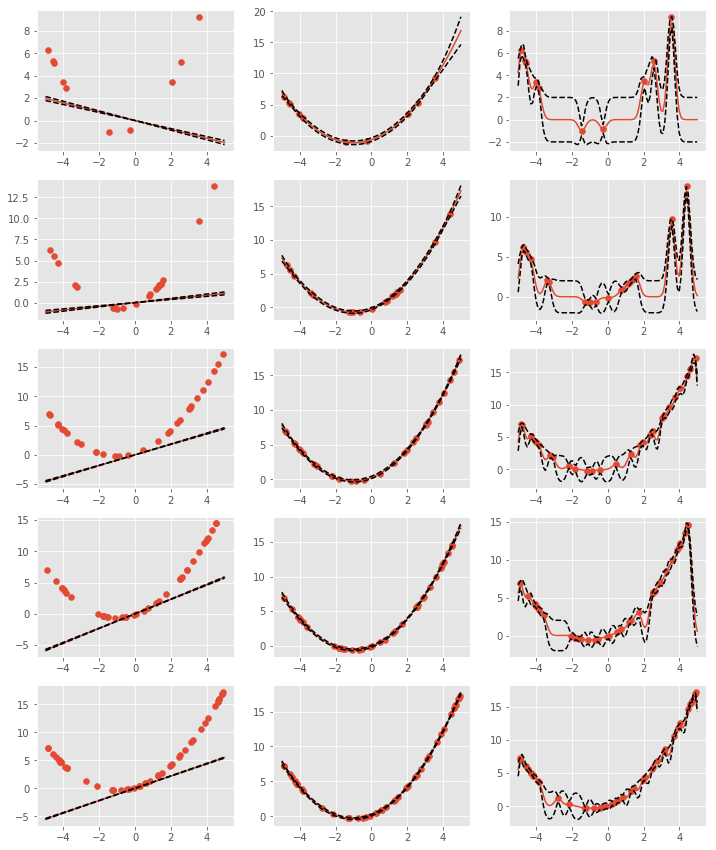

In [7]:
# # 観測変数のスケーリング
# train_y_max = np.max(train_y)
# train_y_min = np.min(train_y)
# max_min = train_y_max - train_y_min
# scaled_train_y = train_y - train_y_min / (max_min)
# gp = GaussianProcess(kernel, sigma_y)
# gp.fit(train_X, scaled_train_y)


max_iter = 5
fig,axes = plt.subplots(nrows=max_iter, ncols=3, figsize=(12, int(max_iter*3)))
for i in range(max_iter):
    # サンプルの生成
    N = 10 * (i+1)
    train_X = np.random.uniform(-5, 5, N)
    train_y = sample(train_X, target)
    
    kernels = [euclid_kernel, poly_kernel, gaussian_kernel]
    for j in range(len(kernels)):
        # 観測変数のスケーリング有り
        gp = GaussianProcess(kernels[j], 0.1)
        gp.fit(train_X, train_y)

        x = np.linspace(-5, 5, 100)
        mu, sigma = gp.pred(x)

        axes[i, j].scatter(train_X, train_y)
        axes[i, j].plot(x, mu)
        axes[i, j].plot(x, mu+2*sigma, "k--")
        axes[i, j].plot(x, mu-2*sigma, "k--")
#         axes[i, j].set_ylim(-5, 5)

plt.show()

# neural process
元論文 : https://arxiv.org/abs/1807.01622

## Pytorch実装の練習 

In [8]:
import torch
import torch.nn as nn

import torchvision
import torchvision.datasets as dsets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Hyperparameters 
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 50
batch_size = 100
learning_rate = 0.001

In [9]:
### データの流し込み方
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

# Dataset Loader (Input Pipline)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
### モデル構築
class MultiLayerPerceptron(nn.Module):

    def __init__(self, input_size, hidden_size, num_classes):
        super(MultiLayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [11]:
### 学習
criterion = nn.CrossEntropyLoss()
model = MultiLayerPerceptron(input_size, hidden_size, num_classes)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
def train(train_loader):
    model.train()
    running_loss = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28 * 28)
        
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

    train_loss = running_loss / len(train_loader)
    
    return train_loss

def valid(test_loader):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images = images.view(-1, 28 * 28)

            outputs = model(images)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / len(test_loader)
    val_acc = float(correct) / total
    
    return val_loss, val_acc

In [12]:
# 実際の学習
loss_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(5):
    loss = train(train_loader)
    val_loss, val_acc = valid(test_loader)

    print('epoch %d, loss: %.4f val_loss: %.4f val_acc: %.4f'
          % (epoch, loss, val_loss, val_acc))
    
    # logging
    loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

epoch 0, loss: 2.2347 val_loss: 2.1632 val_acc: 0.5091
epoch 1, loss: 2.0910 val_loss: 2.0049 val_acc: 0.6625
epoch 2, loss: 1.9205 val_loss: 1.8151 val_acc: 0.7134
epoch 3, loss: 1.7225 val_loss: 1.6043 val_acc: 0.7472
epoch 4, loss: 1.5148 val_loss: 1.3965 val_acc: 0.7796


## neural processの実装

In [13]:
class R_Encoder(torch.nn.Module):
    '''(x_i, y_i) を潜在表現 r_i に変換する
    '''
    
    def __init__(self, input_dim, hidden_dim, r_dim, weight_initializer=torch.nn.init.normal_):
        super(R_Encoder, self).__init__()
        
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, r_dim)
        
        self.softplus = torch.nn.Softplus()
        
        if weight_initializer is not None:
            weight_initializer(self.fc1.weight)
            weight_initializer(self.fc2.weight)
        
    def forward(self, inputs):
        '''inputs : (x_i, y_i)
        '''
        out = self.fc1(inputs)
        out = self.softplus(out)
        out = self.fc2(out)
        return out

In [27]:
class Z_Encoder(torch.nn.Module):
    """R_Encoderで生成されたr_iを元に潜在変数のmu, sigmaを生成する"""
    def __init__(self, r_dim, latent_dim, weight_initializer=torch.nn.init.normal_):
        super(Z_Encoder, self).__init__()
        
        self.mu = torch.nn.Linear(r_dim, latent_dim)
        self.log_var = torch.nn.Linear(r_dim, latent_dim)
        
        if weight_initializer is not None:
            weight_initializer(self.mu.weight)
            weight_initializer(self.log_var.weight)
            
    def forward(self, inputs):
        log_var = self.log_var(inputs)
        print(log_var)
        sigma = torch.exp(log_var).mul(0.5)
        return self.mu(inputs), sigma

In [28]:
class Decoder(torch.nn.Module):
    """ xとそのその他の潜在表現zを使ってyをデコード
    """
    def __init__(self, input_dim, hidden_dim, out_dim, weight_initializer=torch.nn.init.normal_):
        super(Decoder, self).__init__()
        
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.mu = torch.nn.Linear(hidden_dim, out_dim)
        self.log_sigma = torch.nn.Linear(hidden_dim, out_dim)
        
        if weight_initializer is not None:
            weight_initializer(self.fc1.weight)
            weight_initializer(self.mu.weight)
            weight_initializer(self.log_sigma.weight)
        
        self.softplus = torch.nn.Softplus()
        
    def forward(self, x_pred, z):
        """return mu, sigma for every x_pred
        """
        xz = torch.cat([x_pred, z], dim=1)
        out = self.fc1(xz)
        out = self.softplus(out)
        mu = self.mu(out)
        log_sigma = self.log_sigma(out)
        sigma = torch.exp(log_sigma)
        return mu, sigma

In [29]:
def sample_z(mu, std, n):
    '''パラメトライゼーショントリック
    '''
    eps = torch.autograd.Variable(std.data.new(n, latent_dim).normal_())
    return mu + std * eps

def log_likelihood(mu, std, target):
    '''対数尤度の計算
    '''
    norm = torch.distributions.Normal(mu, std)
    return norm.log_prob(target).sum(dim=0).mean()

def KLD_gaussian(mu_q, std_q, mu_p, std_p):
    '''ガウス分布間のKLを計算
    '''
    var_q = std_q**2 + 1e-16
    var_p = std_p**2 + 1e-16
    
    return (var_q/var_p + ((mu_q-mu_p)**2)/var_p + torch.log(var_p/var_q) - 1.0).sum()*0.5

In [30]:
# サンプルの生成
N = 10
train_X = np.random.uniform(-5, 5, N)
train_y = sample(train_X, target)

# torch Tensor化
train_X = torch.from_numpy(train_X.reshape(-1, 1).astype(np.float32))
train_y = torch.from_numpy(train_y.reshape(-1, 1).astype(np.float32))
data = torch.from_numpy(np.c_[train_X, train_y].astype(np.float32))

# 予測分布を見るためのサンプル
X_pred = np.linspace(-5, 5, 100)
X_pred =  torch.from_numpy(X_pred.reshape(-1, 1).astype(np.float32))

In [31]:
x_dim = 1
y_dim = 1
latent_dim = 2

r_dim = 4
hidden_dim = 4
r_encoder = R_Encoder(x_dim+y_dim, hidden_dim, r_dim)
z_encoder = Z_Encoder(r_dim, latent_dim)
decoder = Decoder(x_dim+latent_dim, hidden_dim, y_dim)

In [39]:
# contextから潜在表現を取得
r = r_encoder(data)
r = r.mean(dim=0)
# 潜在表現からmu, sigmaを取得
mu, sigma = z_encoder(r)
# mu, sigmaからzをサンプリング
z = sample_z(mu, sigma, X_pred.shape[0])
mu_pred, sigma_pred = decoder(X_pred, z)

tensor([-7.7029, -9.0256], grad_fn=<AddBackward0>)


In [234]:
def get_context_idx(sample_num):
    num = np.random.randint(1, sample_num)
    idx = np.random.choice(sample_num, num, replace=False)
    return torch.Tensor(idx).long()

In [263]:
### 学習
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
def train(X_all, y_all):
    model.train()
    optimizer.zero_grad()

    # ランダムにcontextを選ぶ
    idx_c = get_context_idx(X_all.shape[0])
    x_c = torch.index_select(X_all, dim=0, index= idx_c)
    y_c = torch.index_select(y_all, dim=0, index= idx_c)

    # contextから潜在表現を取得
    r = r_encoder(torch.cat([x_c, y_c], dim=1))
    r = r.mean(dim=0)

    # mu, sigmaを取得して潜在変数をサンプリング
    mu, sigma = z_encoder(r)
    z = sample_z(mu, sigma, X_all.shape[0])

    # 各点のmu, sigmaを計算する
    mu_pred, sigma_pred = decoder(X_all, z)

    # lossの計算
    Log_L = log_likelihood(mu_pred, sigma_pred, y_all)
    KLD = KLD_gaussian(mu_pred, sigma_pred, mu, sigma)
    loss = -Log_L + KLD

    loss.backward()
    optimizer.step()
    return loss

In [286]:
# データ
sample_num = 20
train_X = np.random.uniform(0, 1, sample_num)
train_y = sample(train_X, target)

X_all = torch.from_numpy(train_X.reshape(-1, 1).astype(np.float32))
y_all = torch.from_numpy(train_y.reshape(-1, 1).astype(np.float32))

# スケーリング
train_y_max = np.max(train_y)
train_y_min = np.min(train_y)
max_min = train_y_max - train_y_min
scaled_train_y = (train_y - train_y_min) / (max_min)
scaled_y_all = torch.from_numpy(scaled_train_y.reshape(-1, 1).astype(np.float32))

# パラメータ
x_dim = 1
y_dim = 1
latent_dim = 2
r_dim = 4
hidden_dim = 4

# モデル生成
r_encoder = R_Encoder(x_dim+y_dim, hidden_dim, r_dim)
z_encoder = Z_Encoder(r_dim, latent_dim)
decoder = Decoder(x_dim+latent_dim, hidden_dim, y_dim)

In [287]:
num_epoch = 10000
for i in range(num_epoch):
    loss = train(X_all, scaled_y_all)
    if (i+1) % 100 == 0:
        print(f"{i+1}th epoch, loss : {loss}")

100th epoch, loss : 32171870208.0
200th epoch, loss : 1215378048.0
300th epoch, loss : 40179101696.0
400th epoch, loss : 6334676.0
500th epoch, loss : 361081077760.0
600th epoch, loss : 4560257548288.0
700th epoch, loss : 1620824162304.0
800th epoch, loss : 2518856853618688.0
900th epoch, loss : 137260081152.0
1000th epoch, loss : 238609678336.0
1100th epoch, loss : 2354200969216.0
1200th epoch, loss : 2396076113920.0
1300th epoch, loss : 10404152320.0
1400th epoch, loss : 421777899520.0
1500th epoch, loss : 8633071616.0
1600th epoch, loss : 1141374582784.0
1700th epoch, loss : 21913516032.0
1800th epoch, loss : 497510489522176.0
1900th epoch, loss : 6.779018050332e+18
2000th epoch, loss : 124903928.0
2100th epoch, loss : 88595447808.0
2200th epoch, loss : 619272404992.0
2300th epoch, loss : 109271534534656.0
2400th epoch, loss : 305765.8125
2500th epoch, loss : 104051376128.0
2600th epoch, loss : 2472175.0
2700th epoch, loss : 426568768.0
2800th epoch, loss : 2616463982592.0
2900th ep

In [284]:
# contextから潜在表現を取得
r = r_encoder(data)
r = r.mean(dim=0)
# 潜在表現からmu, sigmaを取得
mu, sigma = z_encoder(r)
# mu, sigmaからzをサンプリング
z = sample_z(mu, sigma, X_pred.shape[0])
mu_pred, sigma_pred = decoder(X_pred, z)

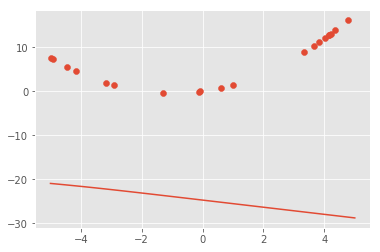

In [285]:
plt.scatter(train_X, train_y)
plt.plot(X_pred.data.numpy(), mu_pred.data.numpy())
plt.show()

In [ ]:
train_y_max = np.max(train_y)
train_y_min = np.min(train_y)
max_min = train_y_max - train_y_min
scaled_train_y = train_y - train_y_min / (max_min)